In [1]:
from __future__ import print_function
from net.models import SAVA_test as SAVA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision.utils import save_image

import argparse
import os
from tqdm import tqdm
import time

from net.network import SelfAttention, vgg_reverse, vgg, SAVANet
from net.models import Transform_SA
from net.models import SAVA_test
from net.models import Transform_test as Transform
from net.utils import adaptive_instance_normalization
%load_ext autoreload
%autoreload 2

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--sava_model', type=str, default='/public/dehezhang2/github/SAVA_Official_Implementation/models/sava_training/',
                    help='Directory path to a batch of content images')
parser.add_argument('--vgg_model', type=str, default='./models/vgg/vgg_normalised.pth')
parser.add_argument('--attn_model', type=str, default='./models/attention_training/attention_kernel_iter_80000.pth')

parser.add_argument('--content_image', type=str, default='./datasets/test/content/lenna.jpg',
                    help='Directory path to a batch of content images')
parser.add_argument('--style_image', type=str, default='./datasets/test/style/candy.jpg',
                    help='Directory path to a batch of style images')
parser.add_argument('--save_image', type=str, default='./test_result/content-02_turner3.jpg',
                    help='Directory path to a batch of style images')
args = parser.parse_args('')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

cuda


torch.Size([3, 512, 512])
torch.Size([3, 512, 512])


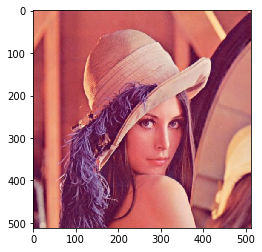

In [4]:
# loading test data

def test_transform(size = 512):
    transform = transforms.Compose([
        transforms.Resize(size=(size, size)),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize((_R_MEAN/255.0, _G_MEAN/255.0, _B_MEAN/255.0), (0.5, 0.5, 0.5))
    ])
    return transform

def test_transform_inv():
    transform = transforms.Compose([
        transforms.Normalize((0, 0, 0), (2, 2, 2)),
        transforms.Normalize((-_R_MEAN/255.0, -_G_MEAN/255.0, -_B_MEAN/255.0), (1, 1, 1))
    ])
    return transform
# scale = 1.40625
content_tf = test_transform(int(512))
style_tf = test_transform(int(512))
content_tf_inv = test_transform_inv()
content = content_tf(Image.open(args.content_image).convert('RGB'))
print(content.shape)

style = style_tf(Image.open(args.style_image).convert('RGB'))
print(style.shape)

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(content_tf_inv(content)))

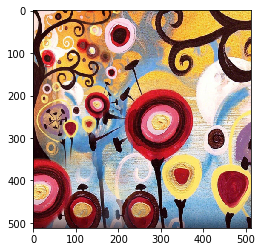

In [5]:
imshow(torchvision.utils.make_grid(content_tf_inv(style)))

In [6]:
def state_to_device(parameter, device):
    state_dict = parameter.state_dict()
    for key in state_dict.keys():
        state_dict[key] = state_dict[key].to(device)
    parameter.cuda()

encoder = vgg
encoder.load_state_dict(torch.load(args.vgg_model))
state_to_device(encoder, device)

self_attn = SelfAttention()
self_attn.load_state_dict(torch.load(args.attn_model))
state_to_device(self_attn, device)

transformer_sa = Transform_SA(in_channel = 512)
transformer_sa.load_state_dict(torch.load('../SANET/transformer_iter_500000.pth'))
state_to_device(transformer_sa, device)

RuntimeError: CUDA error: out of memory

In [ ]:
transformer = Transform(in_channel = 512, self_attn=self_attn, alpha=1, transformer_sa = transformer_sa)

decoder = vgg_reverse
decoder.load_state_dict(torch.load('../SANET/decoder_iter_500000.pth'))
state_to_device(decoder, device)


model = SAVA_test(transformer=transformer, encoder=encoder, decoder=decoder)
# model = SAVA_test(transformer=transformer_sa, encoder=encoder, decoder=decoder)
model.cuda()

In [ ]:
content = torch.stack([content], dim = 0)
content = content.to(device)
style = torch.stack([style], dim = 0)
style = style.to(device)
output, swapped_features, [content_attn4_1, style_attn4_1, content_attn5_1, style_attn5_1] = model.transfer(content, style)
losses = model(content, style)

In [ ]:
def imshow_recon(img, save_dir=None):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if save_dir != None:
        torchvision.utils.save_image(img, save_dir)
    
    
def show_output(output, save_dir=None):
    print("Saving to " + str(save_dir))
    content_result = content_tf_inv(output.squeeze())
    imshow_recon(torchvision.utils.make_grid(content_result.cpu()), save_dir)

In [ ]:
# output = adaptive_instance_normalization(output, style)
show_output(output, args.save_image)